 ## George Iniatis - 2329642i

# Deep Learning 2022 - Coursework
## Classifying Plankton!

The aim of this coursework will be for you to design a deep learning architecture to predict identify plankton species from images. 

***Your aim is to design a model that, when given a new image of a plankton speciment would return to which species it belongs to.***

You are free to use any architecture you prefer, from what we have seen in class. You can decide to use unsupervised pre-training of only supervised end-to-end training - the approach you choose is your choice. 

### Hand-in date: Friday 25th of March before 4:30pm (on Moodle)

### Steps & Hints
* First, look at the data. What are the different classes? How different are they? What type of transformations for your data augmentation do you think would be acceptable here?. 
* You will note that it is *very* imbalanced (large differences in number of samples between classes) --- this will be one challenge to look for. 
* Also, note that the dataset is rather small (hint: you will need to think about data augmentation!). 
* Second, try and load the data and separate into training, validation and test set (or better, use cross-validation)
* Write a DataLoader class for the data (Hint: you will want to put the data augmentation in the data loader). 
* Think about pre-processing of the input? The output? Normalisation or not? Data augmentation? Which one? 
* Design a network for the task. What layers? How many? Do you want to use an Autoencoder for unsupervised pre-training? 
* Choose a loss function for your network
* Select optimiser and training parameters (batch size, learning rate)
* Optimise your model, and tune hyperparameters (especially learning rate, momentum etc)
* Analyse the results on the test data. How to measure success? Which classes are recognised well, which are not? Is there confusion between some classes? Look at failure cases. 
* If time allows, go back to drawing board and try a more complex, or better, model. 
* Explain your thought process, justify your choices and discuss the results!

### Submission
* submit ONE zip file on Moodle containing: 
  * **your notebook**: use `File -> download .ipynb` to download the notebook file locally from colab. 
  * **a PDF file** of your notebook's output as you see it: use `File -> print` to generate a PDF. 
* your notebook must clearly contains separate cells for: 
  * setting up your model and data loader
  * training your model from data
  * loading your pretrained model from github/gitlab
  * testing your model on test data. 
* The training cells must be disabled by a flag, such that when running *run all* on your notebook it does
  * load the data
  * load your model 
  * apply the model to the test data
  * analyse and display the results and accuracy 
* In addition provide markup cell:
  * containing your student number at the top
  * to describe and motivate your design choices: architecture, pre-processing, training regime
  * to analyse, describe and comment on your results
  * to provide some discussion on what you think are the limitations of your solution and what could be future work

* **Note that you must put your trained model on a github so that your code can download it.**


### Assessment criteria 
* In order to get a pass mark, you will need to demonstrate that you have designed and trained a deep NN to solve the problem, using sensible approach and reasonable efforts to tune hyper-parameters. You have analysed the results. It is NOT necessary to have any level of accuracy (a network that predicts poorly will always yield a pass mark if it is designed, tuned and analysed sensibly). 
* In order to get a good mark, you will show good understanding of the approach and provide a working solution. 
* in order to get a high mark, you will demonstrate a working approach of gradual improvement between different versions of your solution. 
* bonus marks for attempting something original if well motivated - even if it does not yield increased performance. 
* bonus marks for getting high performance, and some more points are to grab for getting the best performance in the class. 

### Notes
* make sure to clearly set aside training, validation and test sets to ensure proper setting of all hyperparameters. 
* I recommend to start with small models that can be easier to train to set a baseline performance before attempting more complex one. 
* Be mindful of the time!

### Imports

In [1]:
import os
import numpy as np
import pandas as pd
import plotly.express as px
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets

# Loading the data
# we will use wget to get the archive
#!wget --no-check-certificate "https://www.dropbox.com/s/v2udcnt98miwwrq/plankton.pt?dl=1" -O plankton.pt

### Loading the data

The classes in this dataset are: 
tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

And the numbers of examples per class are: 
2.0     257
8.0     235
7.0     219
10.0    157
11.0    135
0.0     134
3.0     110
6.0      92
9.0      76
4.0      70
5.0      67
1.0      65
dtype: int64


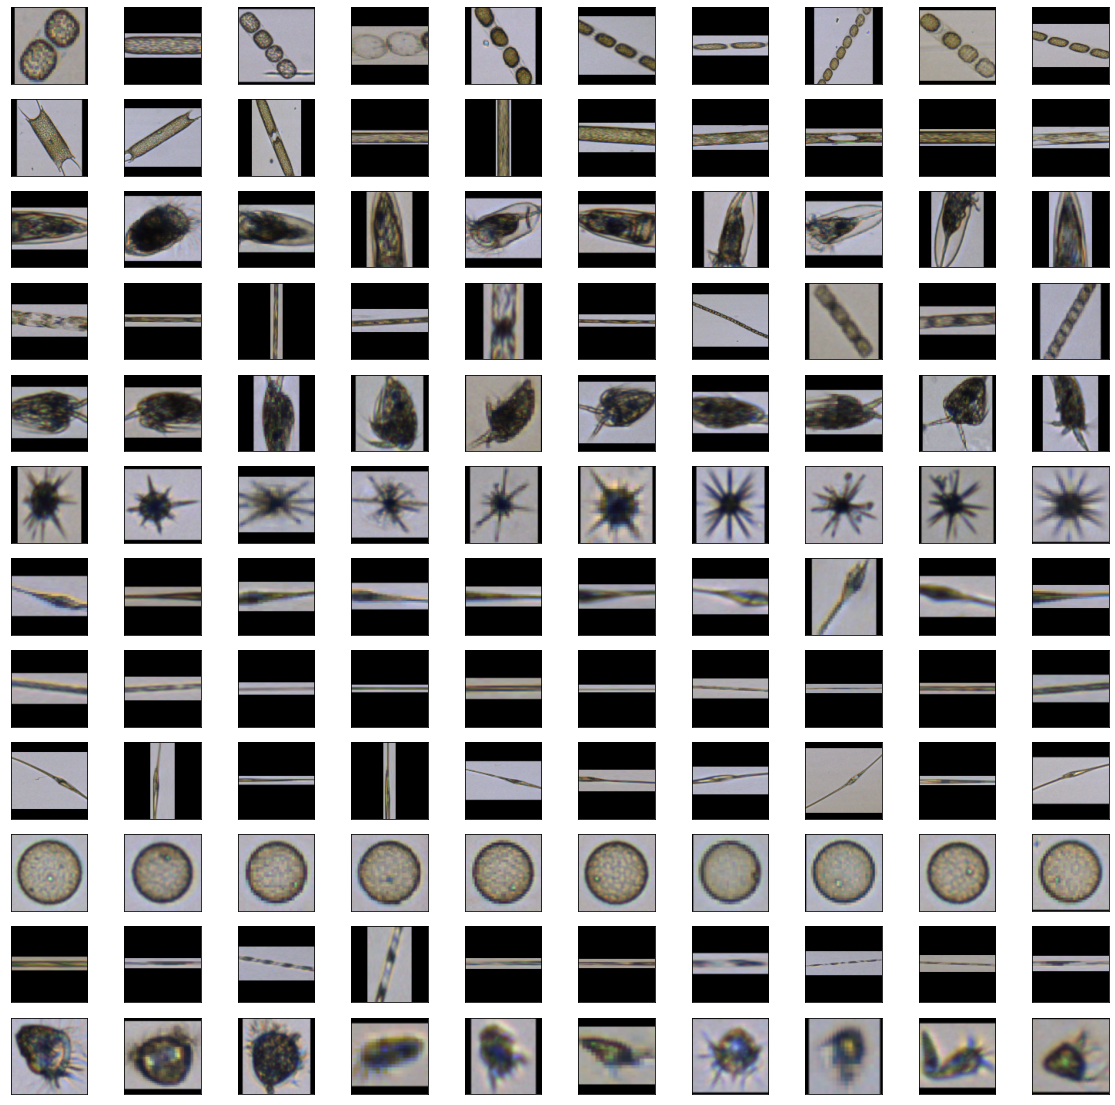

In [2]:
data = torch.load('plankton.pt')

# get the number of different classes
classes = data['labels'].unique()
nclasses = len(classes)
print('The classes in this dataset are: ')
print(classes)

# display the number of instances per class: 
print('\nAnd the numbers of examples per class are: ')
print( pd.Series(data['labels']).value_counts() )

# we now print some examples from each class for visualisation
fig = plt.figure(figsize=(20,20))

n = 10 # number of examples to show per class

for i in range(nclasses): 
  idx = data['labels'] == classes[i]
  imgs = data['images'][idx,...]
  for j in range(n):
    ax = plt.subplot(nclasses,n,i*n+j+1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow( imgs[j,...].permute(1, 2, 0) ) # note the permute because tensorflow puts the channel as the first dimension whereas matplotlib expects WxHx3
plt.show()


torch.Size([3, 100, 100])


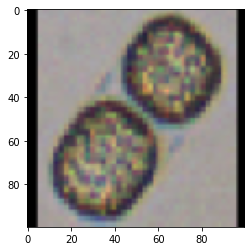

In [3]:
img = data['images'][0]
print(img.shape)
plt.imshow(img.permute(1, 2, 0))

### Data Augmentation

Given the small size of the data we decided to use data augmentation, in the form of various transformations of the original image, to boost the size of the data we are going to use to train our model.

Each original image in the dataset was flipped vertically, flipped horizontally, blurred, had a random part removed 5 times, and randomly rotated 5 times. These transformations allowed us to create 13 new images from a single one, increasing the size of the available images from the original 1617 to 22,638. This substantial change boosted the model's accuracy on the test set from roughly 30% to the current 92%, reiterating the importance of getting as much data as possible even through data augmentation processes.

In [4]:
torch.manual_seed(42)
dtype = torch.float
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class Dataset(torch.utils.data.Dataset):

   def __init__(self, images, labels):
        self.images = images
        self.labels = labels.to(torch.int64)
        self.transform = transform

   def __len__(self):
        return len(self.images)

   def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        
        return image, label

In [6]:
augmented_data = {}
augmented_data["images"] = []
augmented_data["labels"] = []

for i in tqdm(range(len(data['images']))):
    image = data['images'][i]
    augmented_data["images"].append(image)

    # Vertical Flip
    transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.RandomVerticalFlip(p=1.0),
                                    transforms.ToTensor(),
                                    ])
    augmented_data["images"].append(transform(image))
    
    # Horizontal Flip
    transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.RandomHorizontalFlip(p=1.0),
                                    transforms.ToTensor(),
                                    ])
    augmented_data["images"].append(transform(image))
    
    # Blurring
    transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.transforms.GaussianBlur((7,13)),
                                    transforms.ToTensor(),
                                    ])
    augmented_data["images"].append(transform(image))
    
    # Remove random part of image
    transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.ToTensor(),
                                    transforms.RandomErasing(p=1.0),
                                    ])
    
    for n in range(5):
        augmented_data["images"].append(transform(image))
    
    # Rotation
    transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.transforms.RandomRotation((0,360)),
                                    transforms.ToTensor(),
                                    ])
    for k in range(5):
        augmented_data["images"].append(transform(image))
    

    for j in range(14):
        augmented_data["labels"].append(data['labels'][i])

print(f" \nAugmented Data Size: {len(augmented_data['images'])}")

augmented_data['images'] = torch.stack(augmented_data['images'])
augmented_data['labels'] = torch.stack(augmented_data['labels'])

100%|██████████████████████████████████████████████████████████████████████████████| 1617/1617 [00:45<00:00, 35.91it/s]


 
Augmented Data Size: 22638


### Training & Testing Sets

Given the imbalanced nature of the number of images available for each class we decided to use scikit-learn's train_test_split method in order to stratify split our data between the training and testing set, meaning keeping the class imbalances between the two sets.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(augmented_data['images'],
                                                                augmented_data['labels'], 
                                                                stratify=augmented_data['labels'], 
                                                                test_size=0.2, 
                                                                random_state=42)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

torch.Size([18110, 3, 100, 100])
torch.Size([18110])
torch.Size([4528, 3, 100, 100])
torch.Size([4528])


### Dataloaders

In [8]:
BATCH_SIZE = 64

trainloader = torch.utils.data.DataLoader(Dataset(X_train, y_train),
                                                          batch_size=BATCH_SIZE, 
                                                          shuffle=True)

testloader = torch.utils.data.DataLoader(Dataset(X_test, y_test), 
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)

In [9]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 3, 100, 100])
torch.Size([64])


### Our Model

Decided to use the classic approach to create our CNN model. 4 convolutional layers were used followed by relu activation, batch normalisation and max pooling. All dimensions were then flattened except batch and fed into a stack of 4 fully connected linear layers.

In [10]:
class CNN_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.batch_normalisation1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.batch_normalisation2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.batch_normalisation3 = nn.BatchNorm2d(64)
        
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.batch_normalisation4 = nn.BatchNorm2d(128)
        
        self.fc1 = nn.Linear(128*6*6, 512) # Linear
        self.fc2 = nn.Linear(512, 64) # Linear
        self.fc3 = nn.Linear(64, 32) # Linear
        self.fc4 = nn.Linear(32, 12) # Linear
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.batch_normalisation1(x)
        x = F.max_pool2d(x,2,2)
        
        x = F.relu(self.conv2(x))
        x = self.batch_normalisation2(x)
        x = F.max_pool2d(x,2,2)
        
        x = F.relu(self.conv3(x))
        x = self.batch_normalisation3(x)
        x = F.max_pool2d(x,2,2)
        
        x = F.relu(self.conv4(x))
        x = self.batch_normalisation4(x)
        x = F.max_pool2d(x,2,2)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return F.log_softmax(x, dim=-1)

### Training

We trained our model over 250 epochs using a learning rate of 0.001 and a weight decay of 0.0001 fed to an Adam optimiser. 

Looking at the loss graph our model seems to have converged.

**Currently the cell doing the training is commented out.**

In [11]:
epoch_print_gap = 1

def training_loop(n_epochs, optimizer, model, device, loss_fn, train_loader):
    model = model.to(device)
    
    loss_list = []
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs.to(device))
            loss = loss_fn(outputs, labels.to(device))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            
        if epoch == 1 or epoch % epoch_print_gap == 0:
            loss_list.append(loss_train)
            print(f"Epoch: {epoch}, Training Loss: {loss_train}")
    
    torch.save(model.state_dict(), "model_state_dict.pt")
    return loss_list

In [12]:
'''model = CNN_Model()

n_epochs = 250
lr_rate = 0.001
weight_decay = 0.0001

optimizer = optim.Adam(model.parameters(), lr=lr_rate, weight_decay = weight_decay)

loss_fn = nn.CrossEntropyLoss()

loss_list = training_loop(n_epochs = n_epochs, 
                          optimizer = optimizer,
                          model = model,
                          device = device,
                          loss_fn = loss_fn,
                          train_loader = trainloader)


fig = px.line(x=list(i for i in range(1,n_epochs+1)), 
                  y=loss_list, 
                  title="Loss Over Epochs",
                 labels={
                     "x": "Epoch",
                     "y": "Cross Entropy Loss"}) 
fig.write_image("loss.png")'''

'model = CNN_Model()\n\nn_epochs = 250\nlr_rate = 0.001\nweight_decay = 0.0001\n\noptimizer = optim.Adam(model.parameters(), lr=lr_rate, weight_decay = weight_decay)\n\nloss_fn = nn.CrossEntropyLoss()\n\nloss_list = training_loop(n_epochs = n_epochs, \n                          optimizer = optimizer,\n                          model = model,\n                          device = device,\n                          loss_fn = loss_fn,\n                          train_loader = trainloader)\n\n\nfig = px.line(x=list(i for i in range(1,n_epochs+1)), \n                  y=loss_list, \n                  title="Loss Over Epochs",\n                 labels={\n                     "x": "Epoch",\n                     "y": "Cross Entropy Loss"}) \nfig.write_image("loss.png")'

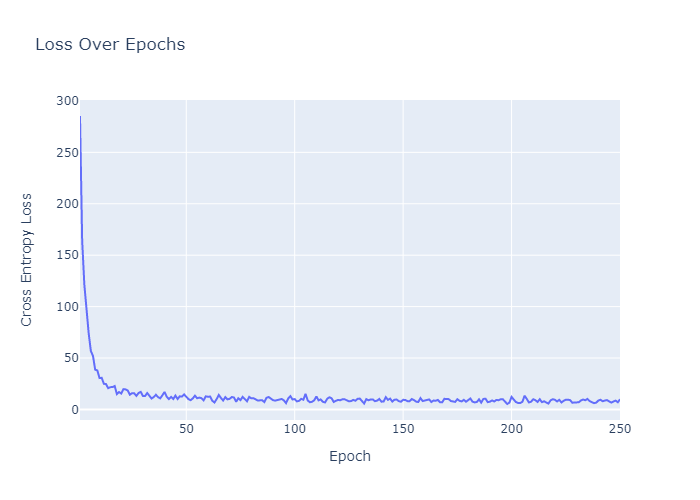

In [13]:
from IPython.display import Image
Image(filename='loss.png') 

### Testing

Our models seems to be doing pretty good, achieving a 92% accuracy on the test set. On closer inspection however one of the classes, Leptocylndrus, achieves only a 80% accuracy which is definetely something that could be investigated and possibly remedied in the future.


In [14]:
label_to_class = dict((v,k) for k,v in data['names'].items())

def test_loop(model, device, test_loader, class_names):
    
    correct_pred = {classname: 0 for classname in class_names}
    total_pred = {classname: 0 for classname in class_names}
    
    model.eval()
    model = model.to(device)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            for i in range(len(target)):
                total_pred[label_to_class[target[i].item()]] += 1
                
                if target[i].item() == pred[i].item():
                    correct_pred[label_to_class[target[i].item()]] += 1

    test_loss /= len(test_loader.dataset)
    
    print(f"Test set: Average Loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%) \n")
    
    for class_name, correct_predictions in correct_pred.items():
        class_accuracy = 100. * correct_predictions / total_pred[class_name]
        print(f'Accuracy for class: {class_name}: {class_accuracy:.0f}%')

In [15]:
model = CNN_Model()
model.load_state_dict(torch.load("model_state_dict.pt"))

test_loop(model = model, device = device, test_loader = testloader, class_names = data['names'].keys())

Test set: Average Loss: 0.3565, Accuracy: 4171/4528 (92%) 

Accuracy for class: Stephanopyxis: 94%
Accuracy for class: Odontella: 92%
Accuracy for class: Parafavella: 98%
Accuracy for class: Lauderia: 91%
Accuracy for class: Barnacle nauplii: 97%
Accuracy for class: Acantharians: 99%
Accuracy for class: C lineatum: 97%
Accuracy for class: Rhizosolenia: 86%
Accuracy for class: C fusus: 87%
Accuracy for class: Halosphaera: 100%
Accuracy for class: Leptocylndrus: 80%
Accuracy for class: Oligortrich ciliate: 99%


### Iterations

Our first iteration was very simple, utilising a model with just 2 convolutional layers and 4 fully connected linear layers, however, without using any data augmnetations. This first iteration achieved an accuracy of 30% on the testing set.

In order to improve upon our first iteration we decided to make use of data augmentaion, creating 5 new images, on a model with 2 more convolutional layers, batch normalisation, dropout and a weight decay of 0.01. This second iteration achieved an accuracy of 76% on the testing set, with our worst performing class, Leptocylndrus, achieving an accuracy of 42%.

For out third iteration we decided to remove dropout layers and decrease the weight decay to 0.001. These changes raised our accuracy on the testing set to 86%, and our worst performing class, Leptocylndrus, achieved an accuracy of 63%.

To try and improve our model's predictive performance we tried to create even more images. We ended up creating 13 new images, which raised our accuracy on the testing set to 92%, and of our worst performing class, Leptocylndrus, to 80%.

Some other notes:
- Learning rates appears to be at its sweet spot
- Increased the weight decay seems to negatively affect the model's predictive performance.